In [1]:
from google.colab import drive
from os.path import join
import os

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Colab Notebooks/'       # path to your project on Drive



drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)


Mounted at /content/drive


In [ ]:
GIT_USERNAME = "ahhuang007" # replace with yours
GIT_TOKEN = os.environ['git_key_wsb']           # definitely replace with yours
GIT_REPOSITORY = "wallstreetbets"      # ...nah


In [ ]:
!mkdir "{PROJECT_PATH}"    # in case we haven't created it already   
%cd "{PROJECT_PATH}"

In [2]:
%cd drive/My Drive/Colab Notebooks/wallstreetbets

/content/drive/My Drive/Colab Notebooks/wallstreetbets


Pulling data from Github

In [3]:
!git pull origin

remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 102 (delta 5), reused 9 (delta 5), pack-reused 88
Receiving objects: 100% (102/102), 1.02 MiB | 1.03 MiB/s, done.
Resolving deltas: 100% (44/44), completed with 3 local objects.
From https://github.com/ahhuang007/wallstreetbets
   95d8f57..36d864a  main       -> origin/main
Updating 95d8f57..36d864a
Fast-forward
 .../envs/__pycache__/actions.cpython-37.pyc        | Bin 699 -> 1103 bytes
 .../envs/__pycache__/val_env.cpython-37.pyc        | Bin 7152 -> 7979 bytes
 .../envs/__pycache__/wsb_env.cpython-37.pyc        | Bin 7316 -> 8095 bytes
 gym-wsb/gym_wsb/envs/actions.py                    |  47 +++++++++++-
 gym-wsb/gym_wsb/envs/val_env.py                    |  34 +++++----
 gym-wsb/gym_wsb/envs/wsb_env.py                    |  43 +++++++----
 main.py                                            |  20 +++--
 models/trained_models/trained_model

Pushing updates to Github

In [ ]:
!git add .

In [ ]:
!git config --global user.email "ahhuang007@gmail.com"
!git config --global user.name "ahhuang007"

In [ ]:
!git commit -m "ok so as it turns out, adding in transaction fees destroys my bot, so pure ML might not work - going to see if integrating the model into my RL approach will do anything"

[main 95d8f57] ok so as it turns out, adding in transaction fees destroys my bot, so pure ML might not work - going to see if integrating the model into my RL approach will do anything
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite colab_ml_testing.ipynb (98%)


In [ ]:
!git remote set-url origin https://$git_key_wsb@github.com/ahhuang007/wallstreetbets.git

In [ ]:
!git push origin

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.34 KiB | 171.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/ahhuang007/wallstreetbets.git
   f33ced4..95d8f57  main -> main


First, deal with data processing

In [4]:
import pandas as pd

In [5]:
#Gathering data, formatting it for training/testing
from sklearn.preprocessing import MinMaxScaler

dfs = []
training_datas = []
cryptos = ['AAVE', 'ADA', 'ALGO', 'ATOM', 
           'AVAX', 'BCH', 'BTC', 'DOT', 
           'ETH', 'LINK', 'LRC', 'LTC', 
           'MANA', 'MATIC', 'SOL', 'UNI']
cryptos = ['BTC']
for c in cryptos:
    df = pd.read_csv('./data/' + c + '_data.csv')
    '''I think we'll do a similar plan to my source idea.
    5 months for training, 2 months for validation/tuning, 5 months for testing
    '''
    #dfs.append(df[38:175200].reset_index(drop = True))
    #Splitting data into training/validation/test
    
    df = df.drop(['timestamp', 'Unnamed: 0'], axis = 1)
    cols = df.columns

    #Normalizing data
    scaler = MinMaxScaler()
    df = pd.DataFrame(data = scaler.fit_transform(df))
    df.columns = cols
    labels = df['close'][1:].reset_index(drop = True)
    increasing_labels = []
    for i in range(len(labels)):
        if labels[i] > df.loc[i, 'close']:
            increasing_labels.append(1)
        else:
            increasing_labels.append(0)
    training = (df[:175200].reset_index(drop = True), labels[:175200].reset_index(drop = True), 
                increasing_labels[:175200])
    validation = (df[175200:282600].reset_index(drop = True), labels[175200:282600].reset_index(drop = True), 
                  increasing_labels[175200:282600])
    testing = (df[262800:-1].reset_index(drop = True), labels[262800:].reset_index(drop = True), 
               increasing_labels[262800:])
    training_datas.append([training, validation, testing])

SGDRegressor

In [6]:
#Import ML stuff, create gridsearch and fit
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

X_train = training_datas[0][0][0]
y_train = training_datas[0][0][1]
X_val = training_datas[0][1][0]
y_val = training_datas[0][1][1]
'''
param_grid = {'loss':('squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'),
              }
'''

sgdreg = SGDRegressor(max_iter = 1000, tol = 1e-4)
sgdreg.fit(X_train.values, y_train.values)

SGDRegressor(tol=0.0001)

In [7]:
sgdreg.score(X_val.values, y_val.values)

0.999920278822661

In [8]:
preds = sgdreg.predict(X_val.values)

In [9]:
preds

array([0.69212919, 0.69309037, 0.69309113, ..., 0.08992483, 0.08937562,
       0.08909382])

In [10]:
y_val

0         0.693338
1         0.693071
2         0.692657
3         0.691590
4         0.692677
            ...   
107395    0.089615
107396    0.089733
107397    0.089067
107398    0.088965
107399    0.089522
Name: close, Length: 107400, dtype: float64

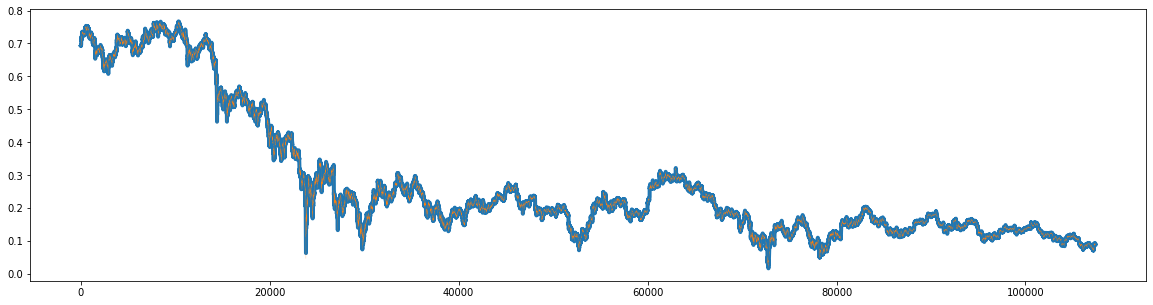

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)
fig = plt.figure()
plt.plot(preds, alpha = 1, linewidth = 4)
plt.plot(y_val, alpha = 1, linewidth = 0.1)
plt.show()

In [12]:
#naive approach - all-in trades, now with fees (assuming always a 0.5% transaction fee)
def sell_low(balance, shares, close):
    if shares > 0:
        #update balance
        balance += shares * close * (1 - 0.005)
        shares = 0
    else:
        pass #No shares to sell!
    return balance, shares

def buy_high(balance, shares, close):
    if balance > 0:
        #update balance
        shares += (((1 - 0.005) * balance) / close)
        balance = 0
        
    else:
        pass
    return balance, shares

In [14]:
#Attempting simulation on validation data
import numpy as np
import time 

balance = 100
shares = 0
counter = 175200
orig_df = pd.read_csv('./data/BTC_data.csv')[175199:]
total = []
cur = orig_df.loc[175199, "close"]
for i in range(len(y_val)):
    if counter % 10000 == 0:
        print("Timestep {}: Balance is {}, shares is {}, total is {}".format(counter, balance, shares, total[-1]))
    pred = sgdreg.predict(np.array(X_val.loc[i,:]).reshape(1, 9))
    cur_norm = X_val.loc[i, 'close']
    #Figuring out which action to take
    if pred > cur_norm:
        balance, shares = buy_high(balance, shares, cur)
        #print("buying")
    elif pred < cur_norm:
        balance, shares = sell_low(balance, shares, cur)
        #print("selling")
    #time.sleep(3)
    total.append(balance + shares * cur)
    #Updating for next step
    counter += 1
    cur = orig_df.loc[counter, "close"]

Timestep 180000: Balance is 0.0010008422581830483, shares is 0, total is 0.0010008422581830483
Timestep 190000: Balance is 0, shares is 7.597961325437538e-19, total is 3.8673630744438397e-14
Timestep 200000: Balance is 0, shares is 1.3534127411718546e-29, total is 5.359789197827002e-25


KeyboardInterrupt: ignored

I mean, all in all not terrible given it's a bear market and our previous best is like $40. So, not bad!

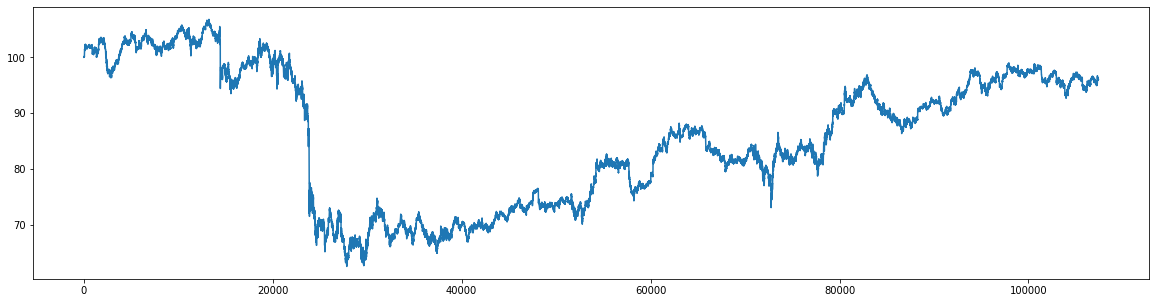

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(total)
plt.show()

In [ ]:
#Testing portion using final 5 months of data
import numpy as np

X_test = training_datas[0][2][0]
y_test = training_datas[0][2][1]
balance = 100
shares = 0
counter = 262800
orig_df = pd.read_csv('./data/BTC_data.csv')[262799:]
test_total = []
cur = orig_df.loc[262799, "close"]
for i in range(len(y_test)):
    if counter % 10000 == 0:
        print("Timestep {}: Balance is {}, shares is {}, total is {}".format(counter, balance, shares, test_total[-1]))
    pred = sgdreg.predict(np.array(X_test.loc[i, :]).reshape(1,8))
    cur_norm = X_test.loc[i, 'close']
    #Figuring out which action to take
    if pred > cur_norm:
        balance, shares = buy_high(balance, shares, cur)
        #print("buying")
    elif pred < cur_norm:
        balance, shares = sell_low(balance, shares, cur)
        #print("selling")
    #time.sleep(3)
    test_total.append(balance + shares * cur)
    #Updating for next step
    counter += 1
    cur = orig_df.loc[counter, "close"]

Timestep 270000: Balance is 110.72608124167431, shares is 0, total is 110.72608124167431
Timestep 280000: Balance is 0, shares is 0.003359517057446133, total is 109.82298215479041
Timestep 290000: Balance is 0, shares is 0.0034939872519460834, total is 112.84443277928968
Timestep 300000: Balance is 0, shares is 0.003334932739259613, total is 133.79703460851218
Timestep 310000: Balance is 131.53399720942824, shares is 0, total is 131.53399720942824
Timestep 320000: Balance is 0, shares is 0.0034412559666403214, total is 159.80136243495895
Timestep 330000: Balance is 0, shares is 0.003494925655664004, total is 158.34326860941988
Timestep 340000: Balance is 0, shares is 0.0034474859612941312, total is 164.5618811780987
Timestep 350000: Balance is 167.6479898160926, shares is 0, total is 167.6479898160926
Timestep 360000: Balance is 161.36905787993211, shares is 0, total is 161.36905787993211
Timestep 370000: Balance is 163.19889665803868, shares is 0, total is 163.19889665803868
Timestep 

Pretty good, but everything looks good in a bull market I guess.

But hang on a second, after checking it looks like we actually beat the bear market as well at the end of the year, so good job me.

In [ ]:
test_total[-1]

195.04552352221637

In [15]:
import pickle

# saving model
with open('./ml_stuff/models/sgdreg_BTC_v1.pkl','wb') as f:
    pickle.dump(sgdreg,f)

In [ ]:
import pickle

# loading model
with open('./ml_stuff/models/sgdreg_v2.pkl', 'rb') as f:
    sgdreg = pickle.load(f)

Other possible approaches - SGDClassifier to test just increasing/decreasing classification, GridSearchCV on various methods, ensemble methods

SGDClassifier approach next

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

X_train = training_datas[0][0][0]
y_train = training_datas[0][0][2]
X_val = training_datas[0][1][0]
y_val = training_datas[0][1][2]

param_grid = {'loss':('hinge', 'log', 'modified_huber', 'perceptron'),
              'penalty':('l2', 'l1', 'elasticnet'),
              'alpha': np.arange(0.0001, 0.01, 0.0004),
              'tol': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001]
              }


sgdclf = SGDClassifier(max_iter = 1000)
grid = GridSearchCV(sgdclf, param_grid)
grid.fit(X_train.values, y_train)
#sgdreg.fit(X_train.values, y_train)

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'alpha': array([0.0001, 0.0005, 0.0009, 0.0013, 0.0017, 0.0021, 0.0025, 0.0029,
       0.0033, 0.0037, 0.0041, 0.0045, 0.0049, 0.0053, 0.0057, 0.0061,
       0.0065, 0.0069, 0.0073, 0.0077, 0.0081, 0.0085, 0.0089, 0.0093,
       0.0097]),
                         'loss': ('hinge', 'log', 'modified_huber',
                                  'perceptron'),
                         'penalty': ('l2', 'l1', 'elasticnet'),
                         'tol': [1e-07, 1e-06, 1e-05, 0.0001, 0.001]})

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

X_train = training_datas[0][0][0]
y_train = training_datas[0][0][2]
X_val = training_datas[0][1][0]
y_val = training_datas[0][1][2]

losses = ['hinge', 'log', 'modified_huber', 'perceptron']
scores = []
for loss in losses:
  sgdclf = SGDClassifier(loss = loss, max_iter = 3000)
  sgdclf.fit(X_train.values, y_train)
  scores.append(sgdclf.score(X_val.values, y_val))
print(scores)

[0.5178957169459962, 0.5147299813780261, 0.5236499068901304, 0.49379888268156424]


In [ ]:
grid.best_params_

{'alpha': 0.0081, 'loss': 'modified_huber', 'penalty': 'l2', 'tol': 1e-05}

In [ ]:
grid.score(X_val.values, y_val)

0.5229888268156424

In [ ]:
sgdclf = SGDClassifier(loss = 'modified_huber', max_iter = 3000, tol = 1e-05, penalty = 'l2', alpha = 0.0081)
sgdclf.fit(X_train.values, y_train)
sgdclf.score(X_val.values, y_val)

0.5251582867783985

In [ ]:
grid.predict(np.array(X_val.loc[1,:]).reshape(1, 8))[0]

0

In [ ]:
#Attempting simulation on validation data (classifier model)
import numpy as np

balance = 100
shares = 0
counter = 175200
orig_df = pd.read_csv('./data/BTC_data.csv')[175199:]
clf_total = []
cur = orig_df.loc[175199, "close"]
for i in range(len(y_val)):
    if counter % 10000 == 0:
        print("Timestep {}: Balance is {}, shares is {}, total is {}".format(counter, balance, shares, clf_total[-1]))
    pred = sgdclf.predict(np.array(X_val.loc[i,:]).reshape(1, 8))[0]
    #Figuring out which action to take
    if pred:
        balance, shares = buy_high(balance, shares, cur)
        #print("buying")
    else:
        balance, shares = sell_low(balance, shares, cur)
        #print("selling")
    #time.sleep(3)
    clf_total.append(balance + shares * cur)
    #Updating for next step
    counter += 1
    cur = orig_df.loc[counter, "close"]

Timestep 180000: Balance is 102.42203710111465, shares is 0, total is 102.42203710111465
Timestep 190000: Balance is 0, shares is 0.0016832530305468183, total is 85.73689709162952
Timestep 200000: Balance is 68.90931980531833, shares is 0, total is 68.90931980531833
Timestep 210000: Balance is 63.41520272903736, shares is 0, total is 63.41520272903736
Timestep 220000: Balance is 60.15970393188905, shares is 0, total is 60.15970393188905
Timestep 230000: Balance is 48.49238540491498, shares is 0, total is 48.49238540491498
Timestep 240000: Balance is 44.937281328441046, shares is 0, total is 44.937281328441046
Timestep 250000: Balance is 37.562080737645594, shares is 0, total is 37.562080737645594
Timestep 260000: Balance is 37.50858293467647, shares is 0, total is 37.50858293467647
Timestep 270000: Balance is 0, shares is 0.0010570461205979568, total is 36.547369619674356
Timestep 280000: Balance is 34.94718092616334, shares is 0, total is 34.94718092616334


Well then, all that work for a piece of shit. Might try ensemble methods later, but I want to see if my SGDRegressor works on live data, so I'm going to go about building that.